In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from geophires_x_client import GeophiresXClient
from geophires_x_client.geophires_input_parameters import GeophiresInputParameters
import numpy as np
from mpmath import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
from pathlib import Path

import pandas as pd

from geophires_x_client import GeophiresXClient
from geophires_x_client.geophires_input_parameters import GeophiresInputParameters


In [8]:
def process_file(file_path):
    client = GeophiresXClient()
    result = client.get_geophires_result(GeophiresInputParameters(from_file_path=file_path))

    all_results = result.result

    # Extracting specific values from all_results
    depth_m = (
        all_results.get('ENGINEERING PARAMETERS', {})
        .get('Well depth (or total length, if not vertical)', {})
        .get('value', None)
    )
    number_of_prod_wells = (
        all_results.get('ENGINEERING PARAMETERS', {}).get('Number of Production Wells', {}).get('value', None)
    )
    number_of_inj_wells = (
        all_results.get('ENGINEERING PARAMETERS', {}).get('Number of Injection Wells', {}).get('value', None)
    )
    max_reservoir_temp = (
        all_results.get('RESOURCE CHARACTERISTICS', {}).get('Maximum reservoir temperature', {}).get('value', None)
    )

    # CAPITAL COSTS
    wellfield_cost = (
        all_results.get('CAPITAL COSTS (M$)', {}).get('Drilling and completion costs', {}).get('value', None)
    )
    surface_plant_cost = (
        all_results.get('CAPITAL COSTS (M$)', {}).get('Surface power plant costs', {}).get('value', None)
    )
    exploration_cost = all_results.get('CAPITAL COSTS (M$)', {}).get('Exploration costs', {}).get('value', None)
    gathering_cost = (
        all_results.get('CAPITAL COSTS (M$)', {}).get('Field gathering system costs', {}).get('value', None)
    )

    # OPERATING AND MAINTENANCE COSTS
    wellfield_OM_cost = (
        all_results.get('OPERATING AND MAINTENANCE COSTS (M$/yr)', {})
        .get('Wellfield maintenance costs', {})
        .get('value', None)
    )
    surface_plant_OM_cost = (
        all_results.get('OPERATING AND MAINTENANCE COSTS (M$/yr)', {})
        .get('Power plant maintenance costs', {})
        .get('value', None)
    )
    water_OM_cost = (
        all_results.get('OPERATING AND MAINTENANCE COSTS (M$/yr)', {}).get('Water costs', {}).get('value', None)
    )

    # SURFACE EQUIPMENT SIMULATION RESULTS
    avg_total_heat_gen = (
        all_results.get('SURFACE EQUIPMENT SIMULATION RESULTS', {})
        .get('Average Total Electricity Generation', {})
        .get('value', None)
    )
    avg_total_electricity_gen = (
        all_results.get('SURFACE EQUIPMENT SIMULATION RESULTS', {})
        .get('Average Total Electricity Generation', {})
        .get('value', None)
    )

    # ECONOMIC PARAMETERS RESULTS
    lifetime = all_results.get('ECONOMIC PARAMETERS', {}).get('Project lifetime', {}).get('value', None)

    # Constructing the dictionary for DataFrame row
    data_row = {
        'Depth (m)': depth_m,
        'Number of Prod Wells': number_of_prod_wells,
        'Number of Inj Wells': number_of_inj_wells,
        'Maximum Reservoir Temperature (deg.C)': max_reservoir_temp,
        'Wellfield Cost ($M)': wellfield_cost,
        'Surface Plant Cost ($M)': surface_plant_cost,
        'Exploration Cost ($M)': exploration_cost,
        'Field Gathering System Cost ($M)': gathering_cost,
        'Wellfield O&M Cost ($M/year)': wellfield_OM_cost,
        'Surface Plant O&M Cost ($M/year)': surface_plant_OM_cost,
        'Make-Up Water O&M Cost ($M/year)': water_OM_cost,
        'Average Reservoir Heat Extraction (MWth)': avg_total_heat_gen,
        'Average Total Electricity Generation (MWe)': avg_total_electricity_gen,
        'Lifetime': lifetime,
    }

    return data_row

plant = 'CHP'
# Specify the folder containing .txt files
folder_path = Path('/Users/bpulluta/python-geophires-x/Engage-Testing/chp_test')

# Find all .txt files in the folder
file_paths = list(folder_path.glob('*.txt'))

# List to store dictionaries of results from each file
df_results = []

# Process each file and append the results to df_results
for file_path in file_paths:
    data_row = process_file(file_path)
    df_results.append(data_row)

df_final = pd.DataFrame(
    df_results,
    columns=[
        'Depth (m)',
        'Number of Prod Wells',
        'Number of Inj Wells',
        'Maximum Reservoir Temperature (deg.C)',
        'Wellfield Cost ($M)',
        'Surface Plant Cost ($M)',
        'Exploration Cost ($M)',
        'Field Gathering System Cost ($M)',
        'Wellfield O&M Cost ($M/year)',
        'Surface Plant O&M Cost ($M/year)',
        'Make-Up Water O&M Cost ($M/year)',
        'Average Reservoir Heat Extraction (MWth)',
        'Average Total Electricity Generation (MWe)',
        'Lifetime',
    ],
)

# Sorting and saving to Excel
df_final = df_final.sort_values(
    by=['Depth (m)', 'Number of Prod Wells', 'Number of Inj Wells'], ascending=[True, True, True]
)
df_final.to_csv('results.csv')


Error: Parameter given (400400.0) for Maximum Temperature outside of valid range. GEOPHIRES will assume default maximum temperature (400 deg.C)
[2023-11-27 22:01:27][CRITICAL] Error: Parameter given (400400.0) for Maximum Temperature outside of valid range. GEOPHIRES will assume default maximum temperature (400 deg.C)


RuntimeError: GEOPHIRES exited without giving a reason

In [4]:
### Scatterplot 
### LINE FIT
df_line = df_final
df_line = pd.concat([df_line, pd.Series(0, index=df_line.columns)], ignore_index=True)

max_e_cap               = np.max(df_line['Average Total Electricity Generation (MWe)'])     ####ADDEDD
max_h_cap               = np.max(df_line['Average Reservoir Heat Extraction (MWth)'])       ####ADDEDD
# plant_efficiency        = np.average(df_line['Efficiency'])                                 ####ADDEDD
# lifecycle               = df_line['Lifetime'][1]                                            ####ADDEDD
# rate                    = df_line['Interest Rate'][1]                                       ####ADDEDD

thermal_capacity_line       = np.array(df_line['Average Reservoir Heat Extraction (MWth)'])
electric_capacity_line      = np.array(df_line['Average Total Electricity Generation (MWe)'])
subsurface_cost_line        = np.add(np.array(df_line['Wellfield Cost ($M)']),
                        # np.array(df_final['Exploration Cost ($M)']),
                        np.array(df_line['Field Gathering System Cost ($M)']))
surface_cost_line           = np.array(df_line['Surface Plant Cost ($M)'])
subsurface_o_m_cost_line    = np.add(np.array(df_line['Wellfield O&M Cost ($M/year)']),
                        np.array(df_line['Make-Up Water O&M Cost ($M/year)']))
surface_o_m_cost_line       = np.array(df_line['Surface Plant O&M Cost ($M/year)'])

###Scatter
thermal_capacity            = np.array(df_final['Average Reservoir Heat Extraction (MWth)'])
electric_capacity           =  np.array(df_final['Average Total Electricity Generation (MWe)'])
subsurface_cost             = np.add(np.array(df_final['Wellfield Cost ($M)']),
                        # np.array(df_final['Exploration Cost ($M)']),
                        np.array(df_final['Field Gathering System Cost ($M)']))
surface_cost                = np.array(df_final['Surface Plant Cost ($M)'])
subsurface_o_m_cost         = np.add(np.array(df_final['Wellfield O&M Cost ($M/year)']),
                        np.array(df_final['Make-Up Water O&M Cost ($M/year)']))
surface_o_m_cost            = np.array(df_final['Surface Plant O&M Cost ($M/year)'])

In [5]:
def fit_linear_model(x, y):
    def objective(x, a, b):
        return a * x + b

    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    x_line = np.asarray([np.min(x), np.max(x)])
    b_values = y - np.multiply(a, x)
    lower_b = np.percentile(b_values, 5)  # 10th percentile as lower bound
    lower_line = objective(x_line, a, lower_b)
    label = f"y={a:.4f}x+{lower_b:.4f}"
    
    return a, lower_b, x_line, lower_line, label

# Example usage:
x1              = thermal_capacity
y1              = subsurface_cost
a1, b1, x1_line, lower_b1_line, label_b1 = fit_linear_model(thermal_capacity, subsurface_cost)

x2              = electric_capacity
y2              = surface_cost
a2, b2, x2_line, lower_b2_line, label_b2 = fit_linear_model(electric_capacity, surface_cost)

x3              = thermal_capacity
y3              = subsurface_o_m_cost
a3, b3, x3_line, lower_b3_line, label_b3 = fit_linear_model(thermal_capacity, subsurface_o_m_cost)

x4              = electric_capacity
y4              = surface_o_m_cost  
a4, b4, x4_line, lower_b4_line, label_b4 = fit_linear_model(electric_capacity, surface_o_m_cost)

/Users/bpulluta/python-geophires-x/geophires/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


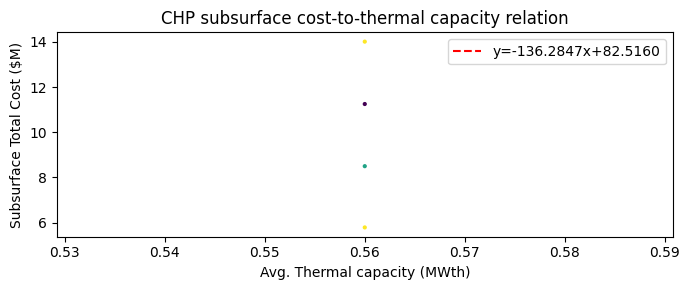

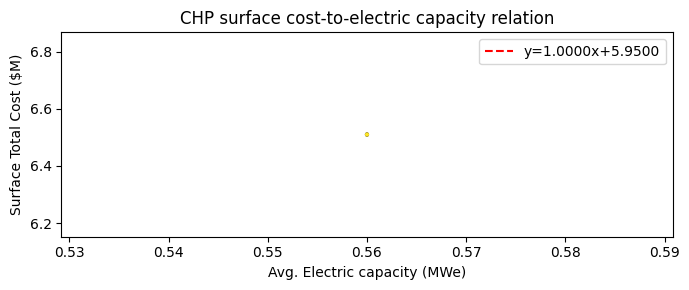

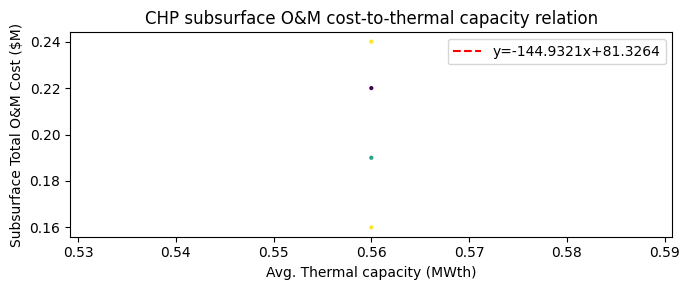

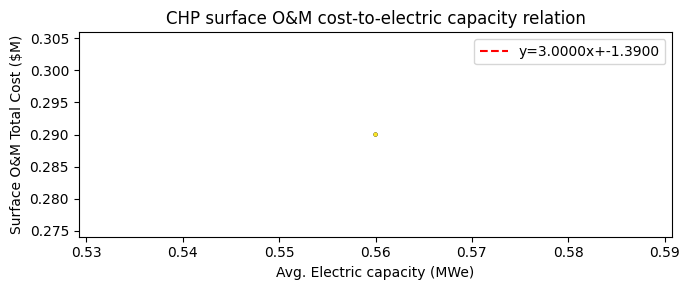

In [6]:
plt.rcParams["figure.figsize"] = [7.00, 3.0]
plt.rcParams["figure.autolayout"] = True    
# define color map
cmap = plt.get_cmap('OrRd')

# find unique values of Number of Prod Wells
unique_prod_wells = df_final['Number of Prod Wells'].unique()

# Plot1
# plt.scatter(x1,y1,color='green',label="Raw data",s=4)
# create scatter plot for each unique value of Number of Prod Wells
fig1 = plt.figure()
for i, prod_wells in enumerate(unique_prod_wells):
    mask = df_final['Number of Prod Wells'] == prod_wells
    x = x1[mask]
    y = y1[mask]
    plt.scatter(x, y, c=cmap(i/len(unique_prod_wells)), label=prod_wells, s=4)
plt.plot(x1_line, lower_b1_line, '--', color='red', label=label_b1)
plt.title(f'{plant} subsurface cost-to-thermal capacity relation')
plt.xlabel('Avg. Thermal capacity (MWth)')
plt.ylabel('Subsurface Total Cost ($M)')
plt.legend(handles=[plt.plot([], [], c='red', ls='--', label=label_b1)[0]])
#add line of best fit to plot
#add fitted regression equation to plot

fig2 = plt.figure()
# Plot2
# plt.scatter(x2,y2,color='blue',label="Raw data",s=4)
for i, prod_wells in enumerate(unique_prod_wells):
    mask = df_final['Number of Prod Wells'] == prod_wells
    x = x2[mask]
    y = y2[mask]
    plt.scatter(x, y, c=cmap(i/len(unique_prod_wells)), label=prod_wells, s=4)
plt.plot(x2_line, lower_b2_line, '--', color='red', label=label_b2)
plt.title(f'{plant} surface cost-to-electric capacity relation')
plt.xlabel('Avg. Electric capacity (MWe)')
plt.ylabel('Surface Total Cost ($M)')
# plt.legend()
plt.legend(handles=[plt.plot([], [], c='red', ls='--', label=label_b2)[0]])

fig3 = plt.figure()
# plt.scatter(x3,y3,color='pink',label="Raw data",s=4)
for i, prod_wells in enumerate(unique_prod_wells):
    mask = df_final['Number of Prod Wells'] == prod_wells
    x = x3[mask]
    y = y3[mask]
    plt.scatter(x, y, c=cmap(i/len(unique_prod_wells)), label=prod_wells, s=4)
plt.plot(x3_line, lower_b3_line, '--', color='red', label=label_b3)
plt.title(f'{plant} subsurface O&M cost-to-thermal capacity relation')
plt.xlabel('Avg. Thermal capacity (MWth)')
plt.ylabel('Subsurface Total O&M Cost ($M)')
# plt.legend()
plt.legend(handles=[plt.plot([], [], c='red', ls='--', label=label_b3)[0]])

#add line of best fit to plot
#add fitted regression equation to plot

fig4 = plt.figure()
# plt.scatter(x4,y4,color='orange',label="Raw data",s=4)
for i, prod_wells in enumerate(unique_prod_wells):
    mask = df_final['Number of Prod Wells'] == prod_wells
    x = x4[mask]
    y = y4[mask]
    plt.scatter(x, y, c=cmap(i/len(unique_prod_wells)), label=prod_wells, s=4)
plt.plot(x4_line, lower_b4_line, '--', color='red', label=label_b4)
plt.title(f'{plant} surface O&M cost-to-electric capacity relation')
plt.xlabel('Avg. Electric capacity (MWe)')
plt.ylabel('Surface O&M Total Cost ($M)')
# plt.legend()
plt.legend(handles=[plt.plot([], [], c='red', ls='--', label=label_b4)[0]])


filename = "results.pdf" 

def save_image(filename):
    p = PdfPages(filename)
    fig_nums = plt.get_fignums()  
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs: 
        fig.savefig(p, format='pdf') 
    p.close()  
    
save_image(filename)  
